# Lesson 3

## Purpose

In this lesson we will learn how to create more complex models with binding, multiple components, and multiple unit operations

## Load CADETSettings

This imports all the standard libraries, finds CADET and find and creates all the lesson folders.

In [1]:
%run CADETSettings.ipynb

CADET was found. Continue to the next step.


## Create a two component Steric Mass Action model

For this we will create a single protein + salt model that has a breakthrough followed by a gradient elution.

Steric Mass Action isotherm math (from the CADET documentation)

Base model:

$$\frac{\mathrm{d} q_i}{\mathrm{d} t} = k_{a,i} c_{p,i}\bar{q}_0^{\nu_i} - k_{d,i} q_i c_{p,0}^{\nu_i}$$

where $c_{p,0}$ denotes the mobile phase salt concentration and

$$\bar{q}_0 = \Lambda - \sum_{j=1}^{N_{\text{comp}} - 1} \left( \nu_j + \sigma_j \right) q_j$$

is the number of available binding sites which is related to the number of bound salt ions. Using the
parameter transformation

$$k_{a,i} = \tilde{k}_{a,i} q_{\text{ref}}^{-\nu_i}$$

$$k_{d,i} = \tilde{k}_{d,i} c_{\text{ref}}^{-\nu_i}$$

we obtain the modified model equation

$$\frac{\mathrm{d} q_i}{\mathrm{d} t} = \tilde{k}_{a,i} c_{p,i} \left(\frac{\bar{q}_0}{q_{\text{ref}}}\right)^{\nu_i} - \tilde{k}_{d,i} q_i \left(\frac{c_{p,0}}{c_{\text{ref}}}\right)^{\nu_i}$$

This transformation serves as a (partial) nondimensionalization of the adsorption and desorption rates

The basic goal is to have $\left(\frac{\bar{q}_0}{q_{\text{ref}}}\right) \leq 1$ and $\left(\frac{c_{p,0}}{c_{\text{ref}}}\right) \leq 1$

Recommended choices for $c_{\text{ref}}$ are the average or maximum inlet concentration of the mobile phase modifier $c_0$, and for $q_{\text{ref}}$ the ionic capacity $\Lambda$.
Note that setting the reference concentrations to ${1.0}$ each results in the original binding model.

**From a practical perspective modern resin capacity is so high that if you don't use reference concentrations the system is often numerically unstable. It may run slowly or not at all.**

CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_3/example_0/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


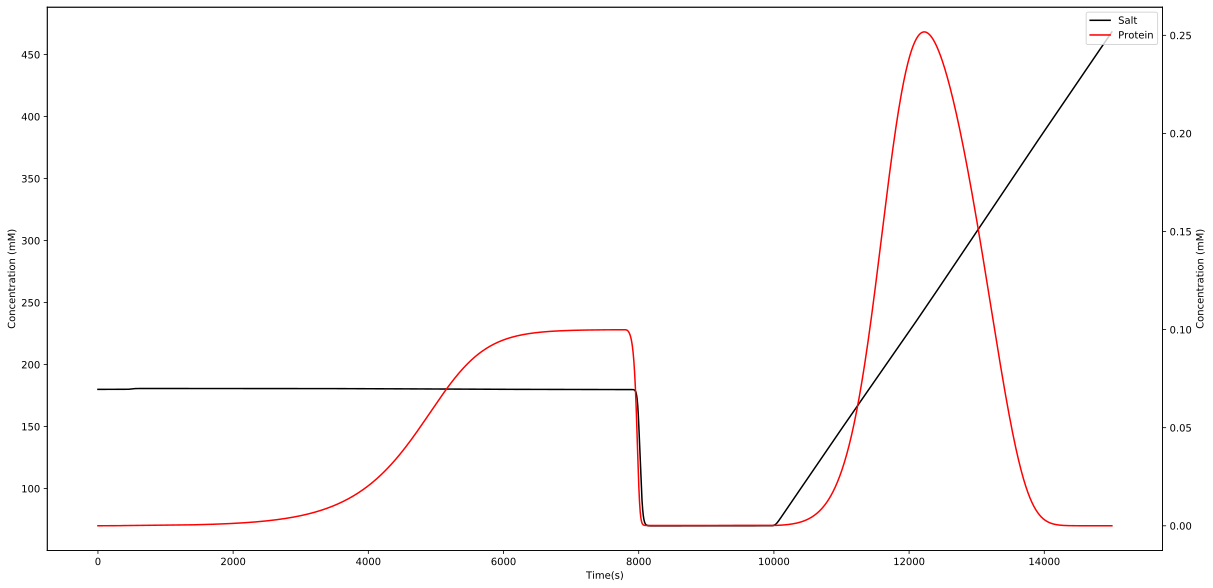

In [2]:
#sma model
example_dir_0 = lesson_3 / "example_0"
example_dir_0.mkdir(exist_ok = True)

example0 = Cadet()

#load a previous simulation to use as the base for the new one
example0.filename = (lesson_2 / "example_0" / 'example.h5').as_posix()
example0.load()

#remove the output from the previous simulation
del example0.root.output

#give a filename for where the simulation should be saved
example0.filename = (example_dir_0 / 'example.h5').as_posix()

#take the original simulation and change just the parts we need

#solver settings
example0.root.input.solver.sections.section_times = [0.0, 7500.0, 9500.0, 15000.0]

#set the times that the simulator writes out data for
example0.root.input.solver.user_solution_times = numpy.linspace(0, example0.root.input.solver.sections.section_times[-1], 
                                                               int(example0.root.input.solver.sections.section_times[-1]) + 1)

#change the inlet
example0.root.input.model.unit_000.ncomp = 2

example0.root.input.model.unit_000.sec_000.const_coeff = [180.0,0.1]
example0.root.input.model.unit_000.sec_000.lin_coeff = [0.0,0.0]
example0.root.input.model.unit_000.sec_000.quad_coeff = [0.0,0.0]
example0.root.input.model.unit_000.sec_000.cube_coeff = [0.0,0.0]

example0.root.input.model.unit_000.sec_001.const_coeff = [70.0,0.0]
example0.root.input.model.unit_000.sec_001.lin_coeff = [0.0,0.0]
example0.root.input.model.unit_000.sec_001.quad_coeff = [0.0,0.0]
example0.root.input.model.unit_000.sec_001.cube_coeff = [0.0,0.0]

example0.root.input.model.unit_000.sec_002.const_coeff = [70.0,0.0]
example0.root.input.model.unit_000.sec_002.lin_coeff = [0.08,0.0]
example0.root.input.model.unit_000.sec_002.quad_coeff = [0.0,0.0]
example0.root.input.model.unit_000.sec_002.cube_coeff = [0.0,0.0]

sma_refc0 = example0.root.input.model.unit_000.sec_002.lin_coeff[0] * (example0.root.input.solver.sections.section_times[-1] - example0.root.input.solver.sections.section_times[-2])

#change the column
example0.root.input.model.unit_001.adsorption_model = 'STERIC_MASS_ACTION'

example0.root.input.model.unit_001.adsorption.is_kinetic = 1
example0.root.input.model.unit_001.adsorption.sma_ka = [0.0, 0.3]
example0.root.input.model.unit_001.adsorption.sma_kd = [0.0, 1.5]
example0.root.input.model.unit_001.adsorption.sma_lambda = 225.0
example0.root.input.model.unit_001.adsorption.sma_nu = [0.0, 7.0]
example0.root.input.model.unit_001.adsorption.sma_refc0 = sma_refc0
example0.root.input.model.unit_001.adsorption.sma_refq = example0.root.input.model.unit_001.adsorption.sma_lambda
example0.root.input.model.unit_001.adsorption.sma_sigma = [0.0, 50.0]


example0.root.input.model.unit_001.film_diffusion = [2.0E-5, 2.0E-7]
example0.root.input.model.unit_001.init_c = [example0.root.input.model.unit_000.sec_000.const_coeff[0], 0.0]
example0.root.input.model.unit_001.init_q = [example0.root.input.model.unit_001.adsorption.sma_lambda, 0.0]
example0.root.input.model.unit_001.ncomp = 2
example0.root.input.model.unit_001.par_diffusion = [7e-5, 1e-9]
example0.root.input.model.unit_001.par_surfdiffusion = [0.0, 0.0]

example0.root.input.model.unit_001.discretization.nbound = [1,1]

#lower discretization to speed up example for training
example0.root.input.model.unit_001.discretization.ncol = 50
example0.root.input.model.unit_001.discretization.npar = 3

#change the outlet
example0.root.input.model.unit_002.ncomp = 2

#set what values get saved
example0.root.input['return'].unit_000.write_solution_inlet = 1

example0.root.input['return'].unit_001.write_solution_particle = 0
example0.root.input['return'].unit_001.write_solution_solid = 0
example0.root.input['return'].unit_001.write_solution_bulk = 0

example0.root.input['return'].unit_002.write_solution_outlet = 1

#save the simulation
example0.save()

#run the simulation
data = example0.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example0.load()
    
    #plot the simulation
    fig, ax1 = plt.subplots(figsize=[20,10])
        
    ax1.plot(example0.root.output.solution.solution_times,
        example0.root.output.solution.unit_002.solution_outlet_comp_000, 'k', label='Salt')
    ax1.set_xlabel('Time(s)')
    ax1.set_ylabel('Concentration (mM)')
    
    ax2 = ax1.twinx()
    
    ax2.plot(example0.root.output.solution.solution_times,
        example0.root.output.solution.unit_002.solution_outlet_comp_001, 'r', label='Protein')
    ax2.set_ylabel('Concentration (mM)')
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2)
    plt.show()
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([example0.root.output.solution.solution_times,
                        example0.root.output.solution.unit_002.solution_outlet_comp_001]).transpose()
    data.to_csv((example_dir_0 / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Writing out more data and making data for Excel

Pandas is a data analysis library for python and so far we have only used it to create CSV files. It can be used for plotting and many type of data analysis beyond the scope of this tutorial. We highly suggest you look into the Pandas library documentation at https://pandas.pydata.org/pandas-docs/stable/ .

We are going to look at a simple example of writing data to an Excel file and also write out data for multiple components to multiple tabs in Excel.

You can then open the file in Excel, look at the numbers, plot them etc.

In [3]:
xlsx_path = example_dir_0 / 'example.xlsx'

data = numpy.array([example0.root.output.solution.solution_times,
                         example0.root.output.solution.unit_000.solution_inlet_comp_000,
                         example0.root.output.solution.unit_000.solution_inlet_comp_001,
                         example0.root.output.solution.unit_002.solution_outlet_comp_000,
                        example0.root.output.solution.unit_002.solution_outlet_comp_001]).transpose()

df = pandas.DataFrame(data, columns=['Time', 'SaltIn', 'ProteinIn', 'SaltOut', 'ProteinOut'])

with pandas.ExcelWriter(xlsx_path.as_posix()) as writer:
    df.to_excel(writer, sheet_name='SaltIn', columns=['Time', 'SaltIn'], index=False)
    df.to_excel(writer, sheet_name='ProteinIn', columns=['Time', 'ProteinIn'], index=False)
    df.to_excel(writer, sheet_name='SaltOut', columns=['Time', 'SaltOut'], index=False)
    df.to_excel(writer, sheet_name='ProteinOut', columns=['Time', 'ProteinOut'], index=False)
    
    
example_dir_0_path = str(example_dir_0)
!explorer "{example_dir_0_path}"

## Create a 3-component Steric Mass Action model

We will take the previous 1-component model and upgrade it to 2-components.

CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_3/example_1/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


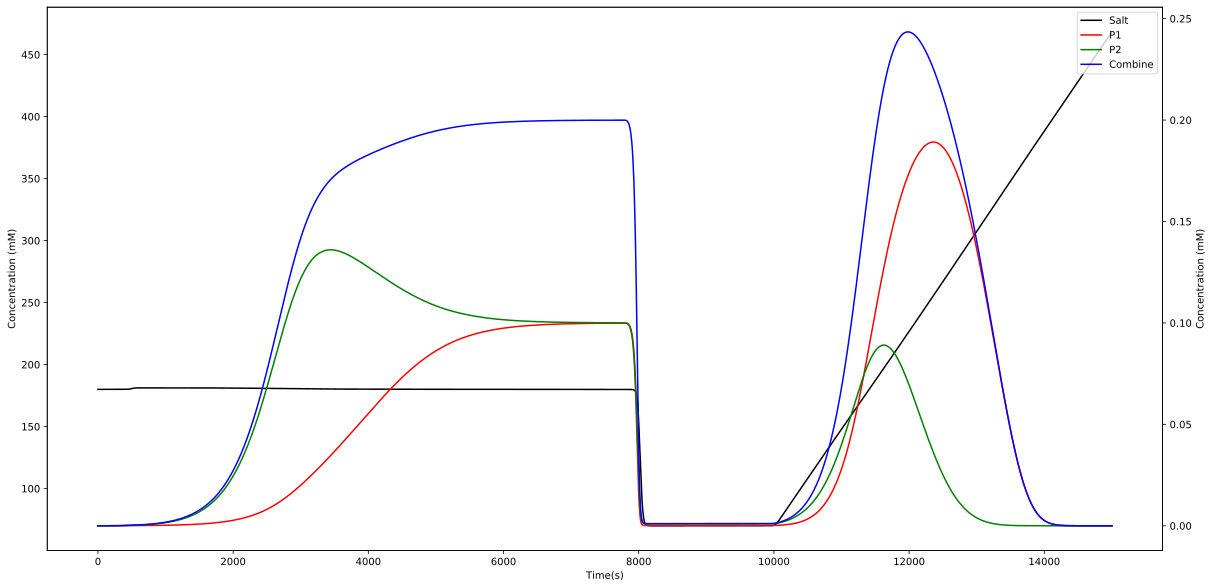

In [4]:
#sma 2-component model
example_dir_1 = lesson_3 / "example_1"
example_dir_1.mkdir(exist_ok = True)

example1 = Cadet()

#load a previous simulation to use as the base for the new one
example1.filename = (lesson_3 / "example_0" / 'example.h5').as_posix()
example1.load()

#remove the output from the previous simulation
del example1.root.output

#give a filename for where the simulation should be saved
example1.filename = (example_dir_1 / 'example.h5').as_posix()

#take the original simulation and change just the parts we need

#solver settings
example1.root.input.solver.sections.section_times = [0.0, 7500.0, 9500.0, 15000.0]

#set the times that the simulator writes out data for
example1.root.input.solver.user_solution_times = numpy.linspace(0, example1.root.input.solver.sections.section_times[-1], 
                                                               int(example1.root.input.solver.sections.section_times[-1]) + 1)

#change the inlet
example1.root.input.model.unit_000.ncomp = 3

example1.root.input.model.unit_000.sec_000.const_coeff = [180.0,0.1,0.1]
example1.root.input.model.unit_000.sec_000.lin_coeff = [0.0,0.0,0.0]
example1.root.input.model.unit_000.sec_000.quad_coeff = [0.0,0.0,0.0]
example1.root.input.model.unit_000.sec_000.cube_coeff = [0.0,0.0,0.0]

example1.root.input.model.unit_000.sec_001.const_coeff = [70.0,0.0, 0.0]
example1.root.input.model.unit_000.sec_001.lin_coeff = [0.0,0.0,0.0]
example1.root.input.model.unit_000.sec_001.quad_coeff = [0.0,0.0,0.0]
example1.root.input.model.unit_000.sec_001.cube_coeff = [0.0,0.0,0.0]

example1.root.input.model.unit_000.sec_002.const_coeff = [70.0,0.0,0.0]
example1.root.input.model.unit_000.sec_002.lin_coeff = [0.08,0.0, 0.0]
example1.root.input.model.unit_000.sec_002.quad_coeff = [0.0,0.0,0.0]
example1.root.input.model.unit_000.sec_002.cube_coeff = [0.0,0.0,0.0]

sma_refc0 = example1.root.input.model.unit_000.sec_002.lin_coeff[0] * (example1.root.input.solver.sections.section_times[-1] - example1.root.input.solver.sections.section_times[-2])


#change the column
example1.root.input.model.unit_001.adsorption_model = 'STERIC_MASS_ACTION'

example1.root.input.model.unit_001.adsorption.is_kinetic = 1
example1.root.input.model.unit_001.adsorption.sma_ka = [0.0, 2.0, 2.0]
example1.root.input.model.unit_001.adsorption.sma_kd = [0.0, 10.0, 10.0]
example1.root.input.model.unit_001.adsorption.sma_lambda = 225.0
example1.root.input.model.unit_001.adsorption.sma_nu = [0.0, 7.0, 5.0]
example1.root.input.model.unit_001.adsorption.sma_refc0 = sma_refc0
example1.root.input.model.unit_001.adsorption.sma_refq = example1.root.input.model.unit_001.adsorption.sma_lambda
example1.root.input.model.unit_001.adsorption.sma_sigma = [0.0, 50.0, 50.0]

example1.root.input.model.unit_001.film_diffusion = [2.0E-5, 2.0E-7, 2e-7]
example1.root.input.model.unit_001.init_c = [example1.root.input.model.unit_000.sec_000.const_coeff[0], 0.0, 0.0]
example1.root.input.model.unit_001.init_q = [example1.root.input.model.unit_001.adsorption.sma_lambda, 0.0, 0.0]
example1.root.input.model.unit_001.ncomp = 3
example1.root.input.model.unit_001.par_diffusion = [7e-5, 1e-9, 1e-9]
example1.root.input.model.unit_001.par_surfdiffusion = [0.0, 0.0, 0.0]

example1.root.input.model.unit_001.discretization.nbound = [1,1,1]

#lower discretization to speed up example for training
example1.root.input.model.unit_001.discretization.ncol = 50
example1.root.input.model.unit_001.discretization.npar = 3

#change the outlet
example1.root.input.model.unit_002.ncomp = 3

#set what values get saved
example1.root.input['return'].unit_000.write_solution_bulk = 0
example1.root.input['return'].unit_000.write_solution_flux = 0
example1.root.input['return'].unit_000.write_solution_inlet = 1
example1.root.input['return'].unit_000.write_solution_outlet = 1
example1.root.input['return'].unit_000.write_solution_particle = 0

example1.root.input['return'].unit_001 = example1.root.input['return'].unit_000
example1.root.input['return'].unit_002 = example1.root.input['return'].unit_000

#save the simulation
example1.save()

#run the simulation
data = example1.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example1.load()
    
    #plot the simulation
    fig, ax1 = plt.subplots(figsize=[20,10])
        
    ax1.plot(example1.root.output.solution.solution_times,
        example1.root.output.solution.unit_002.solution_outlet_comp_000, 'k', label='Salt')
    ax1.set_xlabel('Time(s)')
    ax1.set_ylabel('Concentration (mM)')
    
    ax2 = ax1.twinx()
    
    ax2.plot(example1.root.output.solution.solution_times,
        example1.root.output.solution.unit_002.solution_outlet_comp_001, 'r', label="P1")
    ax2.plot(example1.root.output.solution.solution_times,
        example1.root.output.solution.unit_002.solution_outlet_comp_002, 'g', label="P2")
    ax2.plot(example1.root.output.solution.solution_times,
        example1.root.output.solution.unit_002.solution_outlet_comp_001 + example1.root.output.solution.unit_002.solution_outlet_comp_002, 'b', label='Combine')
    ax2.set_ylabel('Concentration (mM)')
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2)
    plt.show()
    
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([example1.root.output.solution.solution_times,
                        example1.root.output.solution.unit_002.solution_outlet_comp_001]).transpose()
    data.to_csv((example_dir_1 / 'example1.csv').as_posix(), index=False, header=False)
    
    data = pandas.DataFrame([example1.root.output.solution.solution_times,
                        example1.root.output.solution.unit_002.solution_outlet_comp_002]).transpose()
    data.to_csv((example_dir_1 / 'example2.csv').as_posix(), index=False, header=False)
    
    data = pandas.DataFrame([example1.root.output.solution.solution_times,
                        example1.root.output.solution.unit_002.solution_outlet_comp_001 + example1.root.output.solution.unit_002.solution_outlet_comp_002]).transpose()
    data.to_csv((example_dir_1 / 'example1_2.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Add multiple unit operations

CADET supports multiple unit operations. It has been tested more than a thousand unit operations.

A real system does not have an inlet connected directly to the column which connects directly to the outlet. Real systems have tubes and mixing valves. If you don't account for them the pulse that arrives in your column will be far too sharp and the output from your column will be more diffuse than the real column along with having to adjust the data to account for the time spent in tubing and mixing valves. The correct way to deal with this is to model this part of your system also. 

You are not looking for a physically correct model, you just need a model that achives the same end result of the profile going into and out of the column. With real tubing you have zero volume connectors which introduce turbulence and tubing of different diameters. What we need is the right volume to account for the time in the tubing (water is incompressible) and the right amount of diffusion to account for the real system.

For this system we are using a LUMPED_RATE_MODEL_WITHOUT_PORES for the tubing and a CSTR as a mixer. We put one tubing in front of the column along with the CSTR and one piece of tubing after the column.

DPFR volume 10.4
CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_3/example_2/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


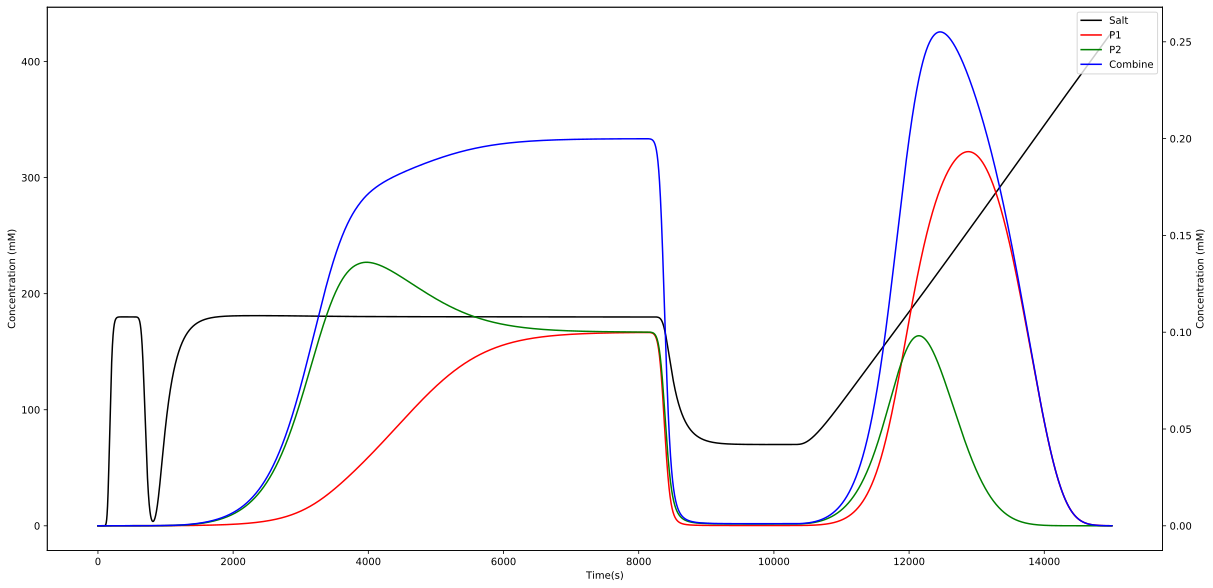

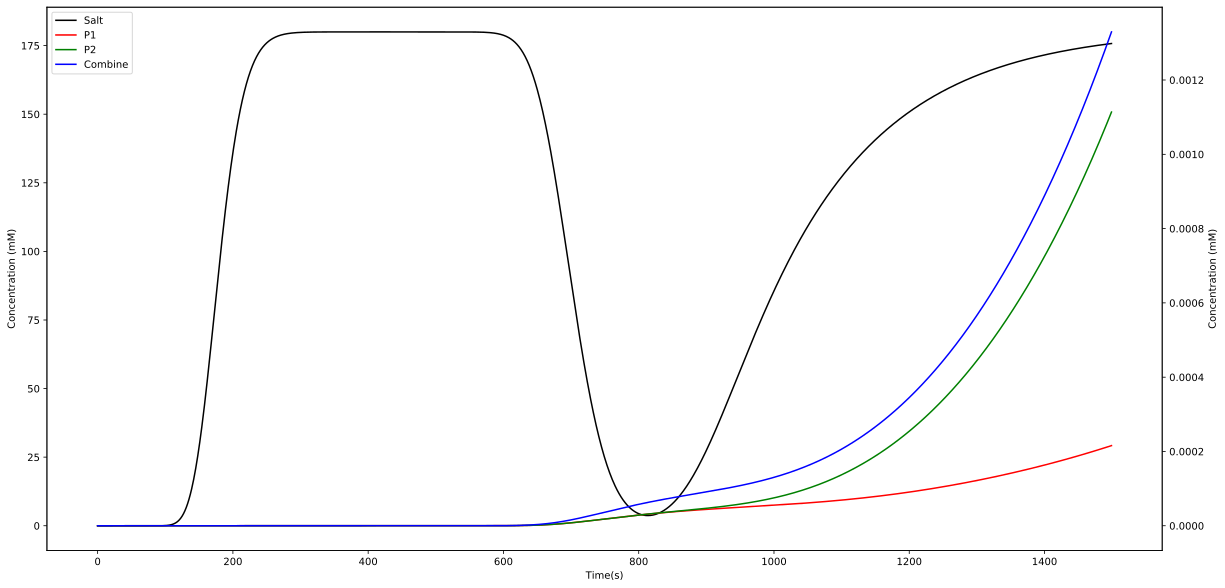

In [5]:
#multiple unit operations
example_dir_2 = lesson_3 / "example_2"
example_dir_2.mkdir(exist_ok = True)

example2 = Cadet()

#load a previous simulation to use as the base for the new one
example2.filename = (lesson_3 / "example_1" / 'example.h5').as_posix()
example2.load()

#remove the output from the previous simulation
del example2.root.output

#give a filename for where the simulation should be saved
example2.filename = (example_dir_2 / 'example.h5').as_posix()

#take the original simulation and change just the parts we need

#set the number of unit operations
example2.root.input.model.nunits = 6

#add two new unit operations to represent the tubing going in and out of the column and also add a small cstr as a mixing valve

#for modeling tubing you can use the LUMPED_RATE_MODEL_WITHOUT_PORES
example2.root.input.model.unit_003.unit_type = 'LUMPED_RATE_MODEL_WITHOUT_PORES'
example2.root.input.model.unit_003.ncomp = 3
example2.root.input.model.unit_003.adsorption_model = 'NONE'
example2.root.input.model.unit_003.init_c = [0.0,0.0,0.0]
example2.root.input.model.unit_003.init_q = [0.0,0.0,0.0]
example2.root.input.model.unit_003.col_dispersion = 2.0e-5
example2.root.input.model.unit_003.col_length = 0.5
example2.root.input.model.unit_003.total_porosity = 1.0
example2.root.input.model.unit_003.velocity = 1
example2.root.input.model.unit_003.cross_section_area = 1.0386890710931253E-5

volume = example2.root.input.model.unit_003.col_length * example2.root.input.model.unit_003.cross_section_area * 1e6  #convert m^3 to mL

print("DPFR volume %.3g" % (volume*2))

#discretization column settings
example2.root.input.model.unit_003.discretization.ncol = 40
example2.root.input.model.unit_003.discretization.nbound = [0,0,0]
example2.root.input.model.unit_003.discretization.use_analytic_jacobian = 1

#example2.root.input.model.unit_003.init_c = [180.0, 0.0, 0.0]

#make a copy of the tubing as another unit operation
example2.root.input.model.unit_004 = example2.root.input.model.unit_003.copy()


#create the mixer as a CSTR
example2.root.input.model.unit_005.unit_type = 'CSTR'
example2.root.input.model.unit_005.ncomp = 3
example2.root.input.model.unit_005.init_volume = 5e-6
example2.root.input.model.unit_005.init_c = [0.0,0.0,0.0]

#example2.root.input.model.unit_005.init_c = [180.0, 0.0, 0.0]


#this connects unit 0 to unit 1 and unit 1 to unit 2 with 2.88e-8 m^3/s with all components
example2.root.input.model.connections.switch_000.connections = [0, 5, -1, -1, 2.88e-8,
                                                             5, 3, -1, -1, 2.88e-8,
                                                              3, 1, -1, -1, 2.88e-8,
                                                             1, 4, -1, -1, 2.88e-8,
                                                             4, 2, -1, -1, 2.88e-8]


#solver settings
example2.root.input.solver.sections.section_times = [0.0, 7500.0, 9500.0, 15000.0]

#set the times that the simulator writes out data for
example2.root.input.solver.user_solution_times = numpy.linspace(0, example2.root.input.solver.sections.section_times[-1], 
                                                               int(example2.root.input.solver.sections.section_times[-1]) + 1)

#default numeric settings
numeric_default(example2)

#save the simulation
example2.save()

#run the simulation
data = example2.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example2.load()
    
    #plot the simulation
    fig, ax1 = plt.subplots(figsize=[20,10])
        
    ax1.plot(example2.root.output.solution.solution_times,
        example2.root.output.solution.unit_002.solution_outlet_comp_000, 'k', label='Salt')
    ax1.set_xlabel('Time(s)')
    ax1.set_ylabel('Concentration (mM)')
    
    ax2 = ax1.twinx()
    
    ax2.plot(example2.root.output.solution.solution_times,
        example2.root.output.solution.unit_002.solution_outlet_comp_001, 'r', label="P1")
    ax2.plot(example2.root.output.solution.solution_times,
        example2.root.output.solution.unit_002.solution_outlet_comp_002, 'g', label="P2")
    ax2.plot(example2.root.output.solution.solution_times,
        example2.root.output.solution.unit_002.solution_outlet_comp_001 + example2.root.output.solution.unit_002.solution_outlet_comp_002, 'b', label='Combine')
    ax2.set_ylabel('Concentration (mM)')
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2)
    plt.show()
    
    #plot zoom in
    fig, ax1 = plt.subplots(figsize=[20,10])
    
    selected = example2.root.output.solution.solution_times < 1500
        
    ax1.plot(example2.root.output.solution.solution_times[selected],
        example2.root.output.solution.unit_002.solution_outlet_comp_000[selected], 'k', label='Salt')
    ax1.set_xlabel('Time(s)')
    ax1.set_ylabel('Concentration (mM)')
    
    ax2 = ax1.twinx()
    
    ax2.plot(example2.root.output.solution.solution_times[selected],
        example2.root.output.solution.unit_002.solution_outlet_comp_001[selected], 'r', label="P1")
    ax2.plot(example2.root.output.solution.solution_times[selected],
        example2.root.output.solution.unit_002.solution_outlet_comp_002[selected], 'g', label="P2")
    ax2.plot(example2.root.output.solution.solution_times[selected],
        example2.root.output.solution.unit_002.solution_outlet_comp_001[selected] + example2.root.output.solution.unit_002.solution_outlet_comp_002[selected], 'b', label='Combine')
    ax2.set_ylabel('Concentration (mM)')
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2)
    plt.show()
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([example2.root.output.solution.solution_times,
                        example2.root.output.solution.unit_002.solution_outlet_comp_001]).transpose()
    data.to_csv((example_dir_2 / 'example1.csv').as_posix(), index=False, header=False)
    
    data = pandas.DataFrame([example2.root.output.solution.solution_times,
                        example2.root.output.solution.unit_002.solution_outlet_comp_002]).transpose()
    data.to_csv((example_dir_2 / 'example2.csv').as_posix(), index=False, header=False)
    
    data = pandas.DataFrame([example2.root.output.solution.solution_times,
                        example2.root.output.solution.unit_002.solution_outlet_comp_001 + example2.root.output.solution.unit_002.solution_outlet_comp_002]).transpose()
    data.to_csv((example_dir_2 / 'example1_2.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Compare 2-component SMA with and without tubing

The solid lines are the original 2-component SMA example and the dash-dot lines are the same simulation with multiple unit operations added.

As you can see the version with multiple unit operations is not just shifting the original example.

Text(0, 0.5, 'Concentration (mM)')

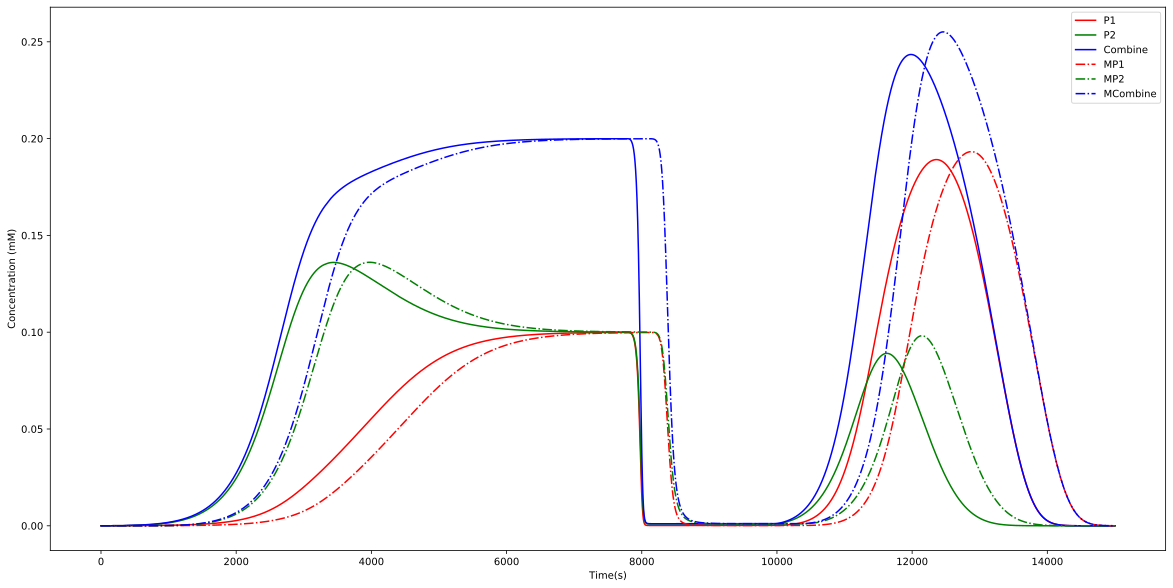

In [6]:
#compare simulations
plt.figure(figsize=[20,10])

plt.plot(example1.root.output.solution.solution_times,
    example1.root.output.solution.unit_002.solution_outlet_comp_001, 'r', label="P1")
plt.plot(example1.root.output.solution.solution_times,
    example1.root.output.solution.unit_002.solution_outlet_comp_002, 'g', label="P2")
plt.plot(example1.root.output.solution.solution_times,
    example1.root.output.solution.unit_002.solution_outlet_comp_001 + example1.root.output.solution.unit_002.solution_outlet_comp_002, 'b', label='Combine')

plt.plot(example2.root.output.solution.solution_times,
    example2.root.output.solution.unit_002.solution_outlet_comp_001, 'r-.', label="MP1")
plt.plot(example2.root.output.solution.solution_times,
    example2.root.output.solution.unit_002.solution_outlet_comp_002, 'g-.', label="MP2")
plt.plot(example2.root.output.solution.solution_times,
    example2.root.output.solution.unit_002.solution_outlet_comp_001 + example2.root.output.solution.unit_002.solution_outlet_comp_002, 'b-.', label='MCombine')

plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('Concentration (mM)')

## Is this just a shift from a longer path?

In [7]:
#compare simulations
def shift(offset=0):
    plt.figure(figsize=[20,10])
    
    times1 = example1.root.output.solution.solution_times
    val11 = example1.root.output.solution.unit_002.solution_outlet_comp_001
    val21 = example1.root.output.solution.unit_002.solution_outlet_comp_002
    comb11 = example1.root.output.solution.unit_002.solution_outlet_comp_001 + example1.root.output.solution.unit_002.solution_outlet_comp_002
    
    val11 = numpy.roll(val11, offset)
    val21 = numpy.roll(val21, offset)
    comb11 = numpy.roll(comb11, offset)

    plt.plot(times1, val11, 'r', label="P1")
    plt.plot(times1, val21, 'g', label="P2")
    plt.plot(times1, comb11, 'b', label='Combine')

    times2 = example2.root.output.solution.solution_times
    val12 = example2.root.output.solution.unit_002.solution_outlet_comp_001
    val22 = example2.root.output.solution.unit_002.solution_outlet_comp_002
    comb12 = example2.root.output.solution.unit_002.solution_outlet_comp_001 + example2.root.output.solution.unit_002.solution_outlet_comp_002
    
    plt.plot(times2, val12, 'r-.', label="MP1")
    plt.plot(times2, val22, 'g-.', label="MP2")
    plt.plot(times2, comb12, 'b-.', label='MCombine')
    
    sse = numpy.sum((comb11 - comb12)**2)
    
    print("SSE Error: %.4g" % sse)

    plt.legend()
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
style = {'description_width': 'initial'}
interact(shift, offset=widgets.IntSlider(min=0, max=700, step=10, value=0, layout={'width': '800px'}, style=style, description='Offset'))

interactive(children=(IntSlider(value=0, description='Offset', layout=Layout(width='800px'), max=700, step=10,…

<function __main__.shift(offset=0)>